# Монтируем диск

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Установка библиотек

In [21]:
# Устанавливаем необходимые библиотеки
!pip install -q openai==1.91.0 langchain==0.3.26 langchain_core==0.3.66 langchain-openai==0.3.27 langchain_community==0.3.26 \
faiss-cpu==1.11.0 tiktoken==0.8.0

In [22]:
# импортируем необходимые библиотеки
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain.text_splitter import (MarkdownHeaderTextSplitter,
                                     RecursiveCharacterTextSplitter,
                                     CharacterTextSplitter)
import os
import re
import requests
import textwrap
import openai
import tiktoken
from glob import glob
import matplotlib.pyplot as plt
from google.colab import userdata, drive


# Получение ключа API OpenAI из секретов Колаба и установка как переменную окружения
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# Загрузка и обработка документов

In [23]:
# Служебные функции

# функция для загрузки документа Docx по ссылке из гугл драйв
def download_google_doc(url: str) -> str:
    # Извлекаем ID документа из URL
    match_ = re.search(r'/document/d/([a-zA-Z0-9-_]+)', url)
    if not match_:
        raise ValueError("Invalid Google Docs URL")
    doc_id = match_.group(1)
    download_url = f'https://docs.google.com/document/d/{doc_id}/export?format=txt'
    response = requests.get(download_url, stream=True)
    if response.status_code != 200:
        raise RuntimeError("Failed to download the document")
    return response.text


# Функция для форматирования текста по абзацам
def format_text(text, width=120):
    # Разделяем текст на абзацы
    paragraphs = text.split('\n')
    # Форматируем каждый абзац отдельно
    formatted_paragraphs = []
    for paragraph in paragraphs:
        # Используем textwrap.fill для форматирования абзаца, чтобы длина строки не превышала width
        formatted_paragraph = textwrap.fill(paragraph, width)
        formatted_paragraphs.append(formatted_paragraph)
    # Объединяем абзацы с символом новой строки
    return '\n'.join(formatted_paragraphs)


# Функция возвращает количество токенов в строке в зависимости от используемой модели
def num_tokens_from_string(string: str, model='gpt-4o-mini') -> int:
    # Получаем имя кодировки для указанной модели
    encoding_name = tiktoken.encoding_for_model(model).name
    # Получаем объект кодировки на основе имени кодировки
    encoding = tiktoken.get_encoding(encoding_name)
    # Кодируем строку и вычисляем количество токенов
    num_tokens = len(encoding.encode(string))
    # Возвращаем количество токенов
    return num_tokens


# Построение гистограммы распределения количества токенов по чанкам
def create_histogram(chunks):
    print("\nОбщее количество чанков: ", len(chunks))
    # Подсчет токенов для каждого чанка
    try: # для формата чанков LangChain Document
        chunk_token_counts = [num_tokens_from_string(chunk.page_content) for chunk in chunks]
    except: # для текстового формата чанков
        chunk_token_counts = [num_tokens_from_string(chunk) for chunk in chunks]
    # Строим гистограмму
    plt.figure(figsize=(7, 4)) # размер
    plt.hist(chunk_token_counts, bins=10, alpha=0.5, label='Чанки')
    plt.title('Распределение к-ва токенов по чанкам')  # Заголовок графика
    plt.xlabel('К-во токенов в чанке')  # Подпись оси X
    plt.ylabel('К-во чанков')  # Подпись оси Y
    plt.show()  # Отображаем график

# Основной процесс обработки

In [24]:
# Ссылки на базы знаний, которые будем использовать:
# База знаний компании Simble - часть 1 (без разбивки MarkDown)
url_base1_simble = 'https://docs.google.com/document/d/1Z7eZLIPG9URgOFz-yqtJAup-WXhKFIiF'
# База знаний компании Simble - часть 2 (без разбивки MarkDown)
url_base2_simble = 'https://docs.google.com/document/d/1qxJXwHtYNxx6ecf35zhqFYBxSjoA5Mhr'

In [26]:
# ДОБАВЬТЕ ЭТО ПЕРЕД ВЫЗОВОМ split_into_chunks
print("📥 Загружаем документы...")
try:
    text1 = download_google_doc(url_base1_simble)
    text2 = download_google_doc(url_base2_simble)
    print(f"✅ Документы загружены: {len(text1)} и {len(text2)} символов")
except Exception as e:
    print(f"❌ Ошибка загрузки: {e}")
    text1, text2 = "", ""

📥 Загружаем документы...
✅ Документы загружены: 47154 и 49098 символов


# Разбиение текстов на чанки

In [28]:
def split_into_chunks(text1, text2):
    """Разбиение текстов на чанки с подробным выводом результатов"""
    print("\n=== РАЗБИЕНИЕ НА ЧАНКИ ===")

    # Проверяем, что тексты не пустые
    if not text1 or not text2:
        print("❌ Ошибка: один или оба текста пустые")
        print(f"text1 длина: {len(text1) if text1 else 0}")
        print(f"text2 длина: {len(text2) if text2 else 0}")
        return [], []

    try:
        # Создаем сплиттер
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=800,
            chunk_overlap=150,
            separators=["\n\n", "\n", ". ", "! ", "? ", " ", ""]
        )

        # Создаем документы LangChain с метаданными
        doc1 = Document(page_content=text1, metadata={"source": "url_base1_simble", "doc_type": "company_knowledge"})
        doc2 = Document(page_content=text2, metadata={"source": "url_base2_simble", "doc_type": "company_knowledge"})

        print("Разбиваем документ 1 на чанки...")
        chunks1 = text_splitter.split_documents([doc1])
        print("Разбиваем документ 2 на чанки...")
        chunks2 = text_splitter.split_documents([doc2])

        # ВЫВОД РЕЗУЛЬТАТОВ РАЗБИЕНИЯ
        print("\n" + "="*60)
        print("📊 РЕЗУЛЬТАТЫ РАЗБИЕНИЯ НА ЧАНКИ")
        print("="*60)

        # Статистика по документу 1
        if chunks1:
            chunk_sizes1 = [len(chunk.page_content) for chunk in chunks1]
            try:
                chunk_tokens1 = [num_tokens_from_string(chunk.page_content) for chunk in chunks1]
            except Exception as e:
                print(f"⚠️ Ошибка подсчета токенов для doc1: {e}")
                chunk_tokens1 = [0] * len(chunks1)

            print(f"\n📄 ДОКУМЕНТ 1 (url_base1_simble):")
            print(f"   • Исходный текст: {len(text1)} символов")
            print(f"   • Создано чанков: {len(chunks1)}")

            print(f"   • Размеры чанков (символы):")
            print(f"     - Минимальный: {min(chunk_sizes1)}")
            print(f"     - Максимальный: {max(chunk_sizes1)}")
            print(f"     - Средний: {sum(chunk_sizes1) // len(chunk_sizes1)}")

            if chunk_tokens1 and chunk_tokens1[0] > 0:
                print(f"   • Токены в чанках:")
                print(f"     - Минимально: {min(chunk_tokens1)} токенов")
                print(f"     - Максимально: {max(chunk_tokens1)} токенов")
                print(f"     - Среднее: {sum(chunk_tokens1) // len(chunk_tokens1)} токенов")

            # Показываем примеры чанков документа 1
            print(f"\n   📝 Примеры чанков документа 1:")
            for i, chunk in enumerate(chunks1[:3], 1):
                preview = chunk.page_content[:100] + "..." if len(chunk.page_content) > 100 else chunk.page_content
                tokens = num_tokens_from_string(chunk.page_content) if chunk_tokens1 and chunk_tokens1[0] > 0 else "N/A"
                print(f"     {i}. [{len(chunk.page_content)} симв., {tokens} ток.] {preview}")
        else:
            print(f"\n❌ ДОКУМЕНТ 1: не создано ни одного чанка")

        # Статистика по документу 2
        if chunks2:
            chunk_sizes2 = [len(chunk.page_content) for chunk in chunks2]
            try:
                chunk_tokens2 = [num_tokens_from_string(chunk.page_content) for chunk in chunks2]
            except Exception as e:
                print(f"⚠️ Ошибка подсчета токенов для doc2: {e}")
                chunk_tokens2 = [0] * len(chunks2)

            print(f"\n📄 ДОКУМЕНТ 2 (url_base2_simble):")
            print(f"   • Исходный текст: {len(text2)} символов")
            print(f"   • Создано чанков: {len(chunks2)}")

            print(f"   • Размеры чанков (символы):")
            print(f"     - Минимальный: {min(chunk_sizes2)}")
            print(f"     - Максимальный: {max(chunk_sizes2)}")
            print(f"     - Средний: {sum(chunk_sizes2) // len(chunk_sizes2)}")

            if chunk_tokens2 and chunk_tokens2[0] > 0:
                print(f"   • Токены в чанках:")
                print(f"     - Минимально: {min(chunk_tokens2)} токенов")
                print(f"     - Максимально: {max(chunk_tokens2)} токенов")
                print(f"     - Среднее: {sum(chunk_tokens2) // len(chunk_tokens2)} токенов")

            # Показываем примеры чанков документа 2
            print(f"\n   📝 Примеры чанков документа 2:")
            for i, chunk in enumerate(chunks2[:3], 1):
                preview = chunk.page_content[:100] + "..." if len(chunk.page_content) > 100 else chunk.page_content
                tokens = num_tokens_from_string(chunk.page_content) if chunk_tokens2 and chunk_tokens2[0] > 0 else "N/A"
                print(f"     {i}. [{len(chunk.page_content)} симв., {tokens} ток.] {preview}")
        else:
            print(f"\n❌ ДОКУМЕНТ 2: не создано ни одного чанка")

        # Общая статистика только если есть чанки
        if chunks1 or chunks2:
            total_chunks = len(chunks1) + len(chunks2)
            total_chars = sum([len(chunk.page_content) for chunk in chunks1 + chunks2])

            print(f"\n📈 ОБЩАЯ СТАТИСТИКА:")
            print(f"   • Всего чанков: {total_chunks}")
            print(f"   • Всего символов в чанках: {total_chars}")
            print(f"   • Средний размер чанка: {total_chars // total_chunks} символов")

        # Визуализация только если есть чанки
        if chunks1 or chunks2:
            print("\n📊 ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ТОКЕНОВ:")

            if chunks1:
                print("\nДокумент 1 (url_base1_simble) - распределение токенов по чанкам:")
                create_histogram(chunks1)

            if chunks2:
                print("\nДокумент 2 (url_base2_simble) - распределение токенов по чанкам:")
                create_histogram(chunks2)

        print("\n✅ РАЗБИЕНИЕ НА ЧАНКИ ЗАВЕРШЕНО!")
        print("="*60)

        return chunks1, chunks2

    except Exception as e:
        print(f"❌ Ошибка в split_into_chunks: {e}")
        import traceback
        traceback.print_exc()
        return [], []

🚀 ЗАПУСК ПРОЦЕССА ОБРАБОТКИ ДОКУМЕНТОВ
📥 Загружаем документы...
✅ Документы загружены успешно!
   - url_base1_simble: 47154 символов
   - url_base2_simble: 49098 символов

📝 Превью документа 1:
﻿КАСКО в Simble теперь можно приобрести в рассрочку с картой Свобода\n\nТеперь КАСКО в Simble можно приобрести в рассрочку с картой Свобода от Банка Хоум Кредит. Карта Свобода предоставляет возможност...

📝 Превью документа 2:
﻿Электронный полис можно и распечатать, если так удобнее.\n\n- Как убедиться, что полис настоящий?\n - Самый простой способ – ввести серию и номер полиса в соответствующую форму на сайте Российского С...

=== РАЗБИЕНИЕ НА ЧАНКИ ===
Разбиваем документ 1 на чанки...
Разбиваем документ 2 на чанки...

📊 РЕЗУЛЬТАТЫ РАЗБИЕНИЯ НА ЧАНКИ

📄 ДОКУМЕНТ 1 (url_base1_simble):
   • Исходный текст: 47154 символов
   • Создано чанков: 79
   • Размеры чанков (символы):
     - Минимальный: 68
     - Максимальный: 800
     - Средний: 636
   • Токены в чанках:
     - Минимально: 14 токенов
   

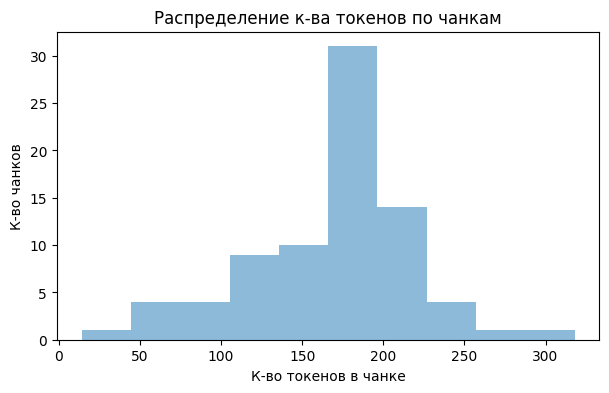


Документ 2 (url_base2_simble) - распределение токенов по чанкам:

Общее количество чанков:  84


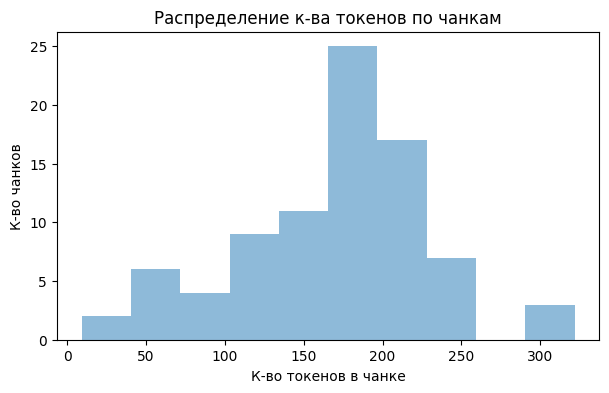


✅ РАЗБИЕНИЕ НА ЧАНКИ ЗАВЕРШЕНО!

🎯 ИТОГО: 163 чанков создано


In [29]:
# ПОЛНЫЙ ПРИМЕР ВЫЗОВА - ДОБАВЬТЕ ЭТО В КОНЕЦ ВАШЕГО КОДА

print("🚀 ЗАПУСК ПРОЦЕССА ОБРАБОТКИ ДОКУМЕНТОВ")
print("="*50)

# 1. Загружаем документы
print("📥 Загружаем документы...")
try:
    text1 = download_google_doc(url_base1_simble)
    text2 = download_google_doc(url_base2_simble)
    print(f"✅ Документы загружены успешно!")
    print(f"   - url_base1_simble: {len(text1)} символов")
    print(f"   - url_base2_simble: {len(text2)} символов")

    # Показываем превью
    print(f"\n📝 Превью документа 1:")
    print(text1[:200] + "..." if len(text1) > 200 else text1)

    print(f"\n📝 Превью документа 2:")
    print(text2[:200] + "..." if len(text2) > 200 else text2)

except Exception as e:
    print(f"❌ Ошибка загрузки документов: {e}")
    text1, text2 = "", ""

# 2. Разбиваем на чанки
if text1 and text2:
    chunks1, chunks2 = split_into_chunks(text1, text2)
    print(f"\n🎯 ИТОГО: {len(chunks1) + len(chunks2)} чанков создано")
else:
    print("❌ Не удалось загрузить документы для обработки")

# Создание отдельных векторных баз и сохранение

In [30]:
def create_and_save_vector_stores(chunks1, chunks2):
    """Создание отдельных векторных баз и сохранение на Google Disk"""
    print("\n=== СОЗДАНИЕ ВЕКТОРНЫХ БАЗ ===")

    try:
        # Инициализируем эмбеддинги
        print("🔄 Инициализируем модель эмбеддингов...")
        embeddings = OpenAIEmbeddings(
            model="text-embedding-3-small",
            openai_api_key=os.environ["OPENAI_API_KEY"]
        )

        # Создаем векторные базы
        print("📦 Создаем векторную базу для документа 1...")
        vector_store1 = FAISS.from_documents(chunks1, embeddings)
        print(f"✅ Векторная база 1 создана: {vector_store1.index.ntotal} векторов")

        print("📦 Создаем векторную базу для документа 2...")
        vector_store2 = FAISS.from_documents(chunks2, embeddings)
        print(f"✅ Векторная база 2 создана: {vector_store2.index.ntotal} векторов")

        # Сохраняем на Google Disk
        print("\n=== СОХРАНЕНИЕ НА GOOGLE DISK ===")

        # Базовый путь в Google Drive
        base_path = "/content/drive/MyDrive/Neuro-staff/13/faiss_databases"

        # Создаем директорию если не существует
        os.makedirs(base_path, exist_ok=True)
        print(f"📁 Создана директория: {base_path}")

        # Пути для сохранения
        store_path1 = f"{base_path}/faiss_base1_simble"
        store_path2 = f"{base_path}/faiss_base2_simble"

        # Сохраняем векторные базы
        print("💾 Сохраняем векторную базу 1...")
        vector_store1.save_local(store_path1)
        print(f"✅ Векторная база 1 сохранена: {store_path1}")

        print("💾 Сохраняем векторную базу 2...")
        vector_store2.save_local(store_path2)
        print(f"✅ Векторная база 2 сохранена: {store_path2}")

        # Проверяем сохраненные файлы
        print("\n=== ПРОВЕРКА СОХРАНЕННЫХ ФАЙЛОВ ===")

        files1 = [f for f in os.listdir(store_path1) if os.path.isfile(os.path.join(store_path1, f))]
        files2 = [f for f in os.listdir(store_path2) if os.path.isfile(os.path.join(store_path2, f))]

        print(f"📄 Файлы в базе 1 ({len(files1)}):")
        for file in files1:
            file_path = os.path.join(store_path1, file)
            size_kb = os.path.getsize(file_path) / 1024
            print(f"   - {file} ({size_kb:.1f} KB)")

        print(f"📄 Файлы в базе 2 ({len(files2)}):")
        for file in files2:
            file_path = os.path.join(store_path2, file)
            size_kb = os.path.getsize(file_path) / 1024
            print(f"   - {file} ({size_kb:.1f} KB)")

        # Статистика по векторным базам
        print("\n📊 СТАТИСТИКА ВЕКТОРНЫХ БАЗ:")
        print(f"   • База 1: {vector_store1.index.ntotal} векторов")
        print(f"   • База 2: {vector_store2.index.ntotal} векторов")
        print(f"   • Всего: {vector_store1.index.ntotal + vector_store2.index.ntotal} векторов")
        print(f"   • Размерность: {vector_store1.index.d} измерений")

        return store_path1, store_path2, base_path, vector_store1, vector_store2

    except Exception as e:
        print(f"❌ Ошибка при создании векторных баз: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None

# Функция для проверки доступности Google Drive
def check_google_drive():
    """Проверка доступности Google Drive"""
    print("🔍 Проверяем доступность Google Drive...")
    try:
        drive_path = "/content/drive/MyDrive"
        if os.path.exists(drive_path):
            print("✅ Google Drive доступен")
            # Показываем свободное место
            stat = os.statvfs(drive_path)
            free_gb = (stat.f_bavail * stat.f_frsize) / (1024**3)
            print(f"   • Свободно места: {free_gb:.1f} GB")
            return True
        else:
            print("❌ Google Drive не доступен")
            return False
    except Exception as e:
        print(f"❌ Ошибка проверки Google Drive: {e}")
        return False

# Полный процесс создания и сохранения векторных баз
def complete_vector_stores_creation(chunks1, chunks2):
    """Полный процесс создания векторных баз"""
    print("🚀 ЗАПУСК СОЗДАНИЯ ВЕКТОРНЫХ БАЗ")
    print("="*50)

    # Проверяем Google Drive
    if not check_google_drive():
        print("❌ Google Drive не доступен. Монтируем...")
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("✅ Google Drive смонтирован")
        except Exception as e:
            print(f"❌ Ошибка монтирования Google Drive: {e}")
            return None, None, None, None, None

    # Проверяем чанки
    if not chunks1 or not chunks2:
        print("❌ Нет чанков для создания векторных баз")
        return None, None, None, None, None

    print(f"📊 Начинаем обработку:")
    print(f"   • Чанков документа 1: {len(chunks1)}")
    print(f"   • Чанков документа 2: {len(chunks2)}")
    print(f"   • Всего чанков: {len(chunks1) + len(chunks2)}")

    # Создаем и сохраняем векторные базы
    result = create_and_save_vector_stores(chunks1, chunks2)

    if result[0]:  # Если store_path1 не None
        store_path1, store_path2, base_path, vector_store1, vector_store2 = result
        print("\n🎉 ВЕКТОРНЫЕ БАЗЫ УСПЕШНО СОЗДАНЫ И СОХРАНЕНЫ!")
        print("="*50)

        # Дополнительная информация
        print("\n📋 ИНФОРМАЦИЯ ДЛЯ СЛЕДУЮЩЕГО ЭТАПА:")
        print(f"   • Путь к базе 1: {store_path1}")
        print(f"   • Путь к базе 2: {store_path2}")
        print(f"   • Основная директория: {base_path}")

        return store_path1, store_path2, base_path, vector_store1, vector_store2
    else:
        print("❌ Не удалось создать векторные базы")
        return None, None, None, None, None

# Запускаем процесс
print("🎯 ПЕРЕХОДИМ К ЭТАПУ 2: СОЗДАНИЕ ВЕКТОРНЫХ БАЗ")
store_path1, store_path2, base_path, vs1, vs2 = complete_vector_stores_creation(chunks1, chunks2)

🎯 ПЕРЕХОДИМ К ЭТАПУ 2: СОЗДАНИЕ ВЕКТОРНЫХ БАЗ
🚀 ЗАПУСК СОЗДАНИЯ ВЕКТОРНЫХ БАЗ
🔍 Проверяем доступность Google Drive...
✅ Google Drive доступен
   • Свободно места: 2.4 GB
📊 Начинаем обработку:
   • Чанков документа 1: 79
   • Чанков документа 2: 84
   • Всего чанков: 163

=== СОЗДАНИЕ ВЕКТОРНЫХ БАЗ ===
🔄 Инициализируем модель эмбеддингов...
📦 Создаем векторную базу для документа 1...
✅ Векторная база 1 создана: 79 векторов
📦 Создаем векторную базу для документа 2...
✅ Векторная база 2 создана: 84 векторов

=== СОХРАНЕНИЕ НА GOOGLE DISK ===
📁 Создана директория: /content/drive/MyDrive/Neuro-staff/13/faiss_databases
💾 Сохраняем векторную базу 1...
✅ Векторная база 1 сохранена: /content/drive/MyDrive/Neuro-staff/13/faiss_databases/faiss_base1_simble
💾 Сохраняем векторную базу 2...
✅ Векторная база 2 сохранена: /content/drive/MyDrive/Neuro-staff/13/faiss_databases/faiss_base2_simble

=== ПРОВЕРКА СОХРАНЕННЫХ ФАЙЛОВ ===
📄 Файлы в базе 1 (2):
   - index.faiss (474.0 KB)
   - index.pkl (97.0 K

# Загрузите отдельных векторных баз и объединение их в одну.

In [31]:
def load_and_merge_vector_stores(store_path1, store_path2, base_path):
    """Загрузка и объединение векторных баз"""
    print("\n=== ЗАГРУЗКА И ОБЪЕДИНЕНИЕ БАЗ ===")

    try:
        # Инициализируем эмбеддинги (должны быть те же самые, что при создании)
        print("🔄 Инициализируем модель эмбеддингов...")
        embeddings = OpenAIEmbeddings(
            model="text-embedding-3-small",
            openai_api_key=os.environ["OPENAI_API_KEY"]
        )

        # Проверяем существование путей
        print("🔍 Проверяем существование векторных баз...")
        if not os.path.exists(store_path1):
            print(f"❌ Путь не существует: {store_path1}")
            return None, None
        if not os.path.exists(store_path2):
            print(f"❌ Путь не существует: {store_path2}")
            return None, None

        # Загружаем сохраненные базы
        print("📥 Загружаем векторную базу 1...")
        vector_store1 = FAISS.load_local(
            store_path1,
            embeddings,
            allow_dangerous_deserialization=True
        )
        print(f"✅ Векторная база 1 загружена: {vector_store1.index.ntotal} векторов")

        print("📥 Загружаем векторную базу 2...")
        vector_store2 = FAISS.load_local(
            store_path2,
            embeddings,
            allow_dangerous_deserialization=True
        )
        print(f"✅ Векторная база 2 загружена: {vector_store2.index.ntotal} векторов")

        # Объединяем базы
        print("🔄 Объединяем векторные базы...")

        # Начинаем с первой базы
        merged_store = vector_store1
        print(f"   Начальный размер объединенной базы: {merged_store.index.ntotal} векторов")

        # Добавляем вторую базу
        merged_store.merge_from(vector_store2)
        print(f"   Конечный размер объединенной базы: {merged_store.index.ntotal} векторов")

        # Проверяем результат объединения
        expected_total = vector_store1.index.ntotal + vector_store2.index.ntotal
        if merged_store.index.ntotal == expected_total:
            print(f"✅ Объединение успешно: {merged_store.index.ntotal} = {vector_store1.index.ntotal} + {vector_store2.index.ntotal}")
        else:
            print(f"⚠️  Возможна проблема с объединением: {merged_store.index.ntotal} != {vector_store1.index.ntotal} + {vector_store2.index.ntotal}")

        # Сохраняем объединенную базу
        print("\n💾 Сохраняем объединенную векторную базу...")
        merged_path = f"{base_path}/faiss_merged_simble"
        merged_store.save_local(merged_path)
        print(f"✅ Объединенная векторная база сохранена: {merged_path}")

        # Проверяем сохраненные файлы объединенной базы
        print("\n=== ПРОВЕРКА ОБЪЕДИНЕННОЙ БАЗЫ ===")
        if os.path.exists(merged_path):
            merged_files = [f for f in os.listdir(merged_path) if os.path.isfile(os.path.join(merged_path, f))]
            print(f"📄 Файлы в объединенной базе ({len(merged_files)}):")
            for file in merged_files:
                file_path = os.path.join(merged_path, file)
                size_kb = os.path.getsize(file_path) / 1024
                print(f"   - {file} ({size_kb:.1f} KB)")
        else:
            print("❌ Объединенная база не найдена")

        # Детальная статистика
        print("\n📊 ДЕТАЛЬНАЯ СТАТИСТИКА ОБЪЕДИНЕННОЙ БАЗЫ:")
        print(f"   • Исходная база 1: {vector_store1.index.ntotal} векторов")
        print(f"   • Исходная база 2: {vector_store2.index.ntotal} векторов")
        print(f"   • Объединенная база: {merged_store.index.ntotal} векторов")
        print(f"   • Размерность: {merged_store.index.d} измерений")
        print(f"   • Путь к объединенной базе: {merged_path}")

        # Проверяем поиск в объединенной базе
        print("\n🔍 ТЕСТИРУЕМ ПОИСК В ОБЪЕДИНЕННОЙ БАЗЕ...")
        try:
            # Простой тестовый запрос
            test_query = "компания"
            results = merged_store.similarity_search(test_query, k=3)
            print(f"✅ Поиск работает: найдено {len(results)} результатов по запросу '{test_query}'")

            # Показываем источники найденных документов
            print("   Источники найденных документов:")
            sources = set()
            for i, doc in enumerate(results, 1):
                source = doc.metadata.get('source', 'Неизвестно')
                sources.add(source)
                content_preview = doc.page_content[:80] + "..." if len(doc.page_content) > 80 else doc.page_content
                print(f"     {i}. [{source}] {content_preview}")

            print(f"   Уникальные источники в результатах: {list(sources)}")

        except Exception as e:
            print(f"⚠️  Тест поиска не удался: {e}")

        return merged_store, merged_path

    except Exception as e:
        print(f"❌ Ошибка при загрузке и объединении векторных баз: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Функция для проверки загруженных баз
def verify_loaded_stores(store_path1, store_path2):
    """Проверка загруженных векторных баз"""
    print("🔍 ПРОВЕРКА ЗАГРУЖЕННЫХ БАЗ...")

    try:
        embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

        # Проверяем первую базу
        print("   Проверяем базу 1...")
        vs1 = FAISS.load_local(store_path1, embeddings, allow_dangerous_deserialization=True)
        print(f"   ✅ База 1: {vs1.index.ntotal} векторов")

        # Проверяем вторую базу
        print("   Проверяем базу 2...")
        vs2 = FAISS.load_local(store_path2, embeddings, allow_dangerous_deserialization=True)
        print(f"   ✅ База 2: {vs2.index.ntotal} векторов")

        # Проверяем метаданные
        print("   Проверяем метаданные...")
        all_docs = list(vs1.docstore._dict.values()) + list(vs2.docstore._dict.values())
        sources = {}
        for doc in all_docs:
            source = doc.metadata.get('source', 'unknown')
            sources[source] = sources.get(source, 0) + 1

        print("   Распределение по источникам:")
        for source, count in sources.items():
            print(f"     - {source}: {count} документов")

        return True

    except Exception as e:
        print(f"   ❌ Ошибка проверки: {e}")
        return False

# Полный процесс загрузки и объединения
def complete_merge_process(store_path1, store_path2, base_path):
    """Полный процесс загрузки и объединения векторных баз"""
    print("🚀 ЗАПУСК ЗАГРУЗКИ И ОБЪЕДИНЕНИЯ ВЕКТОРНЫХ БАЗ")
    print("="*60)

    # Проверяем пути
    print("📁 Проверяем пути к базам:")
    print(f"   • База 1: {store_path1} - {'✅ Существует' if os.path.exists(store_path1) else '❌ Не существует'}")
    print(f"   • База 2: {store_path2} - {'✅ Существует' if os.path.exists(store_path2) else '❌ Не существует'}")
    print(f"   • Базовая директория: {base_path} - {'✅ Существует' if os.path.exists(base_path) else '❌ Не существует'}")

    if not all([os.path.exists(store_path1), os.path.exists(store_path2), os.path.exists(base_path)]):
        print("❌ Не все пути существуют. Прерываем операцию.")
        return None, None

    # Проверяем загруженные базы
    if verify_loaded_stores(store_path1, store_path2):
        print("✅ Все базы загружаются корректно")
    else:
        print("⚠️  Возможны проблемы с загрузкой баз")

    # Загружаем и объединяем
    merged_store, merged_path = load_and_merge_vector_stores(store_path1, store_path2, base_path)

    if merged_store and merged_path:
        print("\n🎉 ОБЪЕДИНЕНИЕ ВЕКТОРНЫХ БАЗ УСПЕШНО ЗАВЕРШЕНО!")
        print("="*60)

        print("\n📋 РЕЗУЛЬТАТЫ ОБЪЕДИНЕНИЯ:")
        print(f"   • Создана объединенная база: {merged_path}")
        print(f"   • Общее количество векторов: {merged_store.index.ntotal}")
        print(f"   • Размерность векторов: {merged_store.index.d}")
        print(f"   • Готова для создания консультанта")

        return merged_store, merged_path
    else:
        print("❌ Не удалось объединить векторные базы")
        return None, None

# Запускаем процесс объединения
print("🎯 ПЕРЕХОДИМ К ЭТАПУ 3: ОБЪЕДИНЕНИЕ ВЕКТОРНЫХ БАЗ")
merged_store, merged_path = complete_merge_process(store_path1, store_path2, base_path)

🎯 ПЕРЕХОДИМ К ЭТАПУ 3: ОБЪЕДИНЕНИЕ ВЕКТОРНЫХ БАЗ
🚀 ЗАПУСК ЗАГРУЗКИ И ОБЪЕДИНЕНИЯ ВЕКТОРНЫХ БАЗ
📁 Проверяем пути к базам:
   • База 1: /content/drive/MyDrive/Neuro-staff/13/faiss_databases/faiss_base1_simble - ✅ Существует
   • База 2: /content/drive/MyDrive/Neuro-staff/13/faiss_databases/faiss_base2_simble - ✅ Существует
   • Базовая директория: /content/drive/MyDrive/Neuro-staff/13/faiss_databases - ✅ Существует
🔍 ПРОВЕРКА ЗАГРУЖЕННЫХ БАЗ...
   Проверяем базу 1...
   ✅ База 1: 79 векторов
   Проверяем базу 2...
   ✅ База 2: 84 векторов
   Проверяем метаданные...
   Распределение по источникам:
     - url_base1_simble: 79 документов
     - url_base2_simble: 84 документов
✅ Все базы загружаются корректно

=== ЗАГРУЗКА И ОБЪЕДИНЕНИЕ БАЗ ===
🔄 Инициализируем модель эмбеддингов...
🔍 Проверяем существование векторных баз...
📥 Загружаем векторную базу 1...
✅ Векторная база 1 загружена: 79 векторов
📥 Загружаем векторную базу 2...
✅ Векторная база 2 загружена: 84 векторов
🔄 Объединяем векторны

# Создание консультанта по объединенной базе

In [34]:
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import time

In [32]:
def create_knowledge_consultant(vector_store):
    """Создание консультанта по объединенной базе знаний"""
    print("\n=== СОЗДАНИЕ КОНСУЛЬТАНТА ===")

    try:
        # Инициализируем языковую модель
        print("🔄 Инициализируем языковую модель...")
        llm = ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=0.1,  # Низкая температура для более точных ответов
            max_tokens=1000,
            openai_api_key=os.environ["OPENAI_API_KEY"]
        )
        print("✅ Языковая модель инициализирована: gpt-3.5-turbo")

        # Создаем ретривер с настройками
        print("🔍 Настраиваем ретривер...")
        retriever = vector_store.as_retriever(
            search_type="mmr",  # Maximum Marginal Relevance для баланса релевантности и разнообразия
            search_kwargs={
                "k": 5,  # Количество возвращаемых чанков
                "fetch_k": 10,  # Количество чанков для рассмотрения
                "lambda_mult": 0.7  # Баланс между релевантностью (1.0) и разнообразием (0.0)
            }
        )
        print("✅ Ретривер настроен: MMR поиск с k=5")

        # Создаем цепочку QA
        print("🔗 Создаем QA цепочку...")
        qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",  # Простой и эффективный для небольших баз
            retriever=retriever,
            return_source_documents=True,
            chain_type_kwargs={
                "verbose": False
            }
        )
        print("✅ QA цепочка создана: chain_type='stuff'")

        # Тестируем консультанта
        print("\n🧪 ТЕСТИРУЕМ КОНСУЛЬТАНТА...")
        test_questions = [
            "Какие основные услуги предоставляет компания?",
            "Каковы принципы обработки персональных данных?"
        ]

        for question in test_questions:
            print(f"\n   Тестовый вопрос: '{question}'")
            try:
                result = qa_chain.invoke({"query": question})
                answer = result["result"]
                sources = result["source_documents"]

                print(f"   🤖 Ответ: {answer[:100]}..." if len(answer) > 100 else f"   🤖 Ответ: {answer}")
                print(f"   📚 Использовано источников: {len(sources)}")

                # Показываем уникальные источники
                unique_sources = set(doc.metadata.get('source', 'Неизвестно') for doc in sources)
                print(f"   📍 Источники: {list(unique_sources)}")

            except Exception as e:
                print(f"   ❌ Ошибка при тестовом запросе: {e}")

        print("\n✅ КОНСУЛЬТАНТ УСПЕШНО СОЗДАН И ПРОТЕСТИРОВАН!")
        return qa_chain, retriever, llm

    except Exception as e:
        print(f"❌ Ошибка при создании консультанта: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Функция для вопросов к консультанту
def ask_consultant(consultant, question, show_sources=True):
    """Задать вопрос консультанту и получить ответ"""
    print(f"\n🤔 ВОПРОС: {question}")
    print("🔍 Ищу информацию в базе знаний...")

    try:
        start_time = time.time()
        result = consultant.invoke({"query": question})
        response_time = time.time() - start_time

        answer = result["result"]
        source_docs = result["source_documents"]

        print(f"✅ Ответ получен за {response_time:.2f} сек.")
        print(f"🤖 ОТВЕТ: {answer}")

        if show_sources and source_docs:
            print(f"\n📚 ИСПОЛЬЗОВАННЫЕ ИСТОЧНИКИ ({len(source_docs)}):")

            # Группируем по источникам
            sources_summary = {}
            for i, doc in enumerate(source_docs, 1):
                source = doc.metadata.get('source', 'Неизвестный источник')
                if source not in sources_summary:
                    sources_summary[source] = []

                content_preview = doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content
                sources_summary[source].append(content_preview)

            # Выводим сгруппированные источники
            for source, contents in sources_summary.items():
                print(f"   📍 {source} ({len(contents)} фрагментов):")
                for j, content in enumerate(contents[:2], 1):  # Показываем первые 2 фрагмента каждого источника
                    print(f"      {j}. {content}")
                if len(contents) > 2:
                    print(f"      ... и еще {len(contents) - 2} фрагментов")

        return answer, source_docs

    except Exception as e:
        print(f"❌ Ошибка при получении ответа: {e}")
        return None, None

# Функция для анализа базы знаний
def analyze_knowledge_base(vector_store):
    """Анализ базы знаний"""
    print("\n📊 АНАЛИЗ БАЗЫ ЗНАНИЙ:")

    try:
        # Получаем все документы из базы
        all_docs = list(vector_store.docstore._dict.values())
        total_docs = len(all_docs)

        print(f"   • Всего документов: {total_docs}")

        # Анализ источников
        sources = {}
        total_chars = 0

        for doc in all_docs:
            source = doc.metadata.get('source', 'unknown')
            sources[source] = sources.get(source, 0) + 1
            total_chars += len(doc.page_content)

        print(f"   • Распределение по источникам:")
        for source, count in sources.items():
            percentage = (count / total_docs) * 100
            print(f"     - {source}: {count} документов ({percentage:.1f}%)")

        print(f"   • Общий объем текста: {total_chars} символов")
        print(f"   • Средний размер документа: {total_chars // total_docs if total_docs > 0 else 0} символов")

        return sources

    except Exception as e:
        print(f"   ❌ Ошибка анализа: {e}")
        return {}

# Полный процесс создания консультанта
def complete_consultant_creation(merged_store):
    """Полный процесс создания консультанта"""
    print("🚀 ЗАПУСК СОЗДАНИЯ КОНСУЛЬТАНТА")
    print("="*50)

    # Анализируем базу знаний
    sources = analyze_knowledge_base(merged_store)

    # Создаем консультанта
    consultant, retriever, llm = create_knowledge_consultant(merged_store)

    if consultant:
        print("\n🎉 КОНСУЛЬТАНТ УСПЕШНО СОЗДАН!")
        print("="*50)

        print("\n📋 ВОЗМОЖНОСТИ КОНСУЛЬТАНТА:")
        print("   • Поиск информации в объединенной базе знаний")
        print("   • Ответы на вопросы на основе документов")
        print("   • Указание источников информации")
        print("   • Баланс между релевантностью и разнообразием ответов")

        print("\n💡 ПРИМЕРЫ ВОПРОСОВ ДЛЯ ТЕСТИРОВАНИЯ:")
        example_questions = [
            "Какие продукты и услуги предлагает компания?",
            "Каковы основные принципы работы с клиентами?",
            "Какие технологии используются в компании?",
            "Какова организационная структура?",
            "Какие требования к сотрудникам?",
            "Какие методы обработки данных используются?"
        ]

        for i, question in enumerate(example_questions, 1):
            print(f"   {i}. {question}")

        return consultant, retriever, llm
    else:
        print("❌ Не удалось создать консультанта")
        return None, None, None

# Импортируем time для измерения скорости ответов
import time

# Запускаем процесс создания консультанта
print("🎯 ПЕРЕХОДИМ К ЭТАПУ 4: СОЗДАНИЕ КОНСУЛЬТАНТА")
consultant, retriever, llm = complete_consultant_creation(merged_store)

🎯 ПЕРЕХОДИМ К ЭТАПУ 4: СОЗДАНИЕ КОНСУЛЬТАНТА
🚀 ЗАПУСК СОЗДАНИЯ КОНСУЛЬТАНТА

📊 АНАЛИЗ БАЗЫ ЗНАНИЙ:
   • Всего документов: 163
   • Распределение по источникам:
     - url_base1_simble: 79 документов (48.5%)
     - url_base2_simble: 84 документов (51.5%)
   • Общий объем текста: 103912 символов
   • Средний размер документа: 637 символов

=== СОЗДАНИЕ КОНСУЛЬТАНТА ===
🔄 Инициализируем языковую модель...
✅ Языковая модель инициализирована: gpt-3.5-turbo
🔍 Настраиваем ретривер...
✅ Ретривер настроен: MMR поиск с k=5
🔗 Создаем QA цепочку...
✅ QA цепочка создана: chain_type='stuff'

🧪 ТЕСТИРУЕМ КОНСУЛЬТАНТА...

   Тестовый вопрос: 'Какие основные услуги предоставляет компания?'
   🤖 Ответ: Компания предоставляет услуги страхования через ООО "Зетта Страхование" и САО "ВСК".
   📚 Использовано источников: 5
   📍 Источники: ['url_base2_simble', 'url_base1_simble']

   Тестовый вопрос: 'Каковы принципы обработки персональных данных?'
   🤖 Ответ: Принципы обработки персональных данных включают в 

# Тестируем консультанта



In [33]:
# ТЕСТИРУЕМ КОНСУЛЬТАНТА С РАЗНЫМИ ВОПРОСАМИ
if consultant:
    print("\n🧪 ТЕСТИРОВАНИЕ КОНСУЛЬТАНТА С РЕАЛЬНЫМИ ВОПРОСАМИ")
    print("="*60)

    test_questions = [
        "Расскажи о компании и её основных направлениях деятельности",
        "Какие услуги предоставляет компания?",
        "Как компания работает с персональными данными?",
        "Какие принципы обработки информации используются?",
        "Опиши основные продукты или решения компании"
    ]

    for question in test_questions:
        answer, sources = ask_consultant(consultant, question, show_sources=True)
        print("\n" + "─" * 80)

    print("\n🎯 КОНСУЛЬТАНТ ГОТОВ К РАБОТЕ!")
else:
    print("❌ Консультант не создан, невозможно протестировать")


🧪 ТЕСТИРОВАНИЕ КОНСУЛЬТАНТА С РЕАЛЬНЫМИ ВОПРОСАМИ

🤔 ВОПРОС: Расскажи о компании и её основных направлениях деятельности
🔍 Ищу информацию в базе знаний...
✅ Ответ получен за 3.61 сек.
🤖 ОТВЕТ: Из предоставленной информации можно сделать вывод, что компания, о которой идет речь, является IT-компанией, которая занимается анализом данных и разработкой стратегий монетизации данных. Основное направление деятельности компании связано с использованием данных для определения потенциальных рынков и установления партнерских отношений для монетизации данных с другими компаниями. Компания также предлагает работу в центре города Москвы, гибкий график работы, возможность удаленной работы по пятницам, конкурентную заработную плату и оформление по ТК РФ.

📚 ИСПОЛЬЗОВАННЫЕ ИСТОЧНИКИ (5):
   📍 url_base2_simble (5 фрагментов):
      1. текущей ситуации и тенденций развития рынков, включая высокотехнологичные (IoT, AI и др.) - желательно.\n- Знание методов анализа рынков и отраслей, о...
      2. . Эта и